In [1]:
import os 
os.environ["HOME"] = "/home/nas4_user/jinhochoi"
import sys
import torch
import numpy as np
import plotly.graph_objects as go
sys.path.append('../../../')
from src.conceptscope.conceptscope_medical import ConceptScope
from src.utils.image_dataset_loader import ImageDatasetLoader
from src.utils.utils import load_class_names
from src.experiments.bias_discovery.utils import get_class_sae_activation, plot_concepts,plot_high_low_images, plot_ref_images

import json

/home/nas4_user/jinhochoi/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nas4_user/jinhochoi/anaconda3/envs/py311/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/nas4_user/jinhochoi/

In [2]:

save_root = '../../../out'
data_root = '../../../data'
dir_name  = 'dataset_analysis'


bacbkbone = 'dinobloom_b'
clip_model = 'openai/clip-vit-large-patch14'
sae_path = f'../../../out/checkpoints/dinobloom_b/final_sparse_autoencoder_dinov2_vitb14_-2_resid_49152.pt'


num_samples = 256
device = 'cuda:7' if torch.cuda.is_available() else 'cpu'

conceptscope = ConceptScope(
    save_root=save_root,
    dir_name=dir_name,
    data_root=data_root,
    backbone=bacbkbone,
    clip_model_name=clip_model,          
    sae_path=sae_path,
    num_samples_for_alignment=num_samples,
    device=device
)

Using cache found in /home/nas4_user/jinhochoi/.cache/torch/hub/facebookresearch_dinov2_main
/home/nas4_user/jinhochoi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/nas4_user/jinhochoi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/nas4_user/jinhochoi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [38]:
dataset_name = 'acevedo'
split = 'train'
train_split = 'train'

test_dataset = ImageDatasetLoader.load_dataset(dataset_name=dataset_name, split=split, root=data_root)
train_dataset = ImageDatasetLoader.load_dataset(dataset_name=dataset_name, split=train_split, root=data_root)
class_names = load_class_names(data_root, dataset_name, test_dataset)

test_labels = np.array(test_dataset['label'])
train_labels = np.array(train_dataset['label'])

concept_dict = conceptscope.run(dataset_name, train_split, target_threshold=1.0)




Running ConceptScope for dataset: acevedo, split: train
Using SAE model checkpoint: dinobloom_b
Load dataset and extract SAE activations
Categorizing concepts based on alignment scores


Categorizing concepts:   0%|          | 0/13 [00:00<?, ?it/s]/home/nas4_user/jinhochoi/repo/temp/ConceptScope/src/experiments/bias_discovery/../../../src/conceptscope/conceptscope_medical.py:350: RuntimeWarning:

Mean of empty slice.

/home/nas4_user/jinhochoi/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide

/home/nas4_user/jinhochoi/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/nas4_user/jinhochoi/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in divide

/home/nas4_user/jinhochoi/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide

/home/nas4_user/jinhochoi/repo/temp/ConceptScope/src/experiments/bias_discovery/../../../src/conceptscope/conceptscope_me

In [ ]:
import plotly.io as pio
import pandas as pd
import plotly.express as px
from src.utils.processor import ImageProcessor
from src.experiments.bias_discovery.utils import  apply_sae_mask_to_input
from PIL import Image
from src.utils.utils import plot_images

def plot_concepts(concept_dict, selected_class, target_threshold=0.1, bias_sigma=1, max_concepts=20, save_fig=False):
    data = {
        "Class aligned": [],
        "Mean": [],
        "Concept Type": [],
        "latent_idx": [],
        "slice_idx": [],
    }

    context_means = []
    len_target = len(concept_dict[str(selected_class)]["target"])
    len_context = max_concepts - len_target
    all_slices = (
        concept_dict[str(selected_class)]["target"] + concept_dict[str(selected_class)]["context"][:len_context]
    )
    for i, slice_info in enumerate(all_slices):
        data["latent_idx"].append(slice_info["latent_idx"])
        data["Mean"].append(slice_info["mean_activation"])
        data["Class aligned"].append(slice_info["normalized_alignment_score"])
        data["slice_idx"].append(i)
        if "bias" not in slice_info:
            data["Concept Type"].append("target")
        else:
            context_means.append(slice_info["mean_activation"])
            if slice_info["bias"] == True:
                data["Concept Type"].append("bias")
            else:
                data["Concept Type"].append("context")

    context_means = np.array(context_means)
    bias_threshold = np.mean(context_means) + bias_sigma * np.std(context_means)

    df = pd.DataFrame(data)
    color_map = {"target": "green", "context": "orange", "bias": "red"}
    df["Color"] = df["Concept Type"].map(color_map)

    df = df.sort_values("Class aligned", ascending=True).reset_index(drop=True)

    fig = px.bar(
        df,
        x="slice_idx",
        y="Mean",
        color="Concept Type",
        color_discrete_map=color_map,
        hover_data={
            "Mean": True,
            "latent_idx": True,
            "Concept Type": True,
            "Class aligned": False,  # hide duplicate
        },
    )

    fig.update_layout(
        xaxis_title="Concepts",
        yaxis_title="Mean Activations",
        xaxis_tickangle=-30,
        xaxis=dict(
            tickmode="array",
            tickvals=df["slice_idx"],
            ticktext=df["latent_idx"],
        ),
        yaxis_title_font=dict(size=18, family="Arial", color="black"),  # increase size
        yaxis=dict(tickfont=dict(size=14), nticks=5),  # Limit to 5 y-axis ticks
        template="plotly_white",
        width=1200,
        height=600,
        font=dict(size=14),
    )
    fig.add_shape(
        type="line",
        x0=len_target - 0.5,
        x1=len(df) - 1,
        y0=bias_threshold,
        y1=bias_threshold,
        line=dict(color="red", width=2, dash="dash"),
    )
    fig.show()

    if save_fig:
        save_dir = "output"
        #os.makedirs(save_dir, exist_ok=True)
        #pio.write_image(fig, f"{save_dir}/classs_{selected_class}_concepts.svg", format="svg")
    return data




def get_high_activating_images(
    activations, idx, class_indices, dataset, resize_size=256, top_k=10, percentile=0, reverse=False
):
    latent_activation = activations[:, idx]

    start_point = int(len(latent_activation) * percentile)

    if reverse:
        latent_activation = -latent_activation
    sort_indices = np.argsort(latent_activation)[::-1][start_point : start_point + top_k]

    images = []
    subset = dataset[class_indices]["image"]
    for idx in sort_indices:
        image = subset[idx]
        if isinstance(image, str):
            image = Image.open(image)
        images.append(image.resize((resize_size, resize_size)))
    return images, sort_indices


def plot_high_low_images(
    latent_idx,
    class_indices,
    class_activation,
    dataset,
    sae,
    vit,
    cfg,
    top_k=10,
    plot_ref=True,
    blend_rate_high=0.5,
    blend_rate_low=0.0,
    gamma=0.5,
    resize_size=256,
    percentile=0,
    device="cuda",
):

    high_images, _ = get_high_activating_images(
        class_activation,
        latent_idx,
        class_indices,
        dataset,
        resize_size=resize_size,
        top_k=top_k,
        percentile=percentile,
        reverse=False,
    )

    low_images, _ = get_high_activating_images(
        class_activation,
        latent_idx,
        class_indices,
        dataset,
        resize_size=resize_size,
        top_k=top_k,
        percentile=percentile,
        reverse=True,
    )

    high_images_masks = get_sae_mask(high_images, sae, vit, cfg, latent_idx, resize_size=resize_size, device=device)
    low_images_masks = get_sae_mask(low_images, sae, vit, cfg, latent_idx, resize_size=resize_size, device=device)

    masked_high_images, _ = apply_sae_mask_to_input(
        high_images, high_images_masks, resize_size=resize_size, blend_rate=blend_rate_high, gamma=gamma, reverse=False
    )
    masked_low_images, _ = apply_sae_mask_to_input(
        low_images, low_images_masks, resize_size=resize_size, blend_rate=blend_rate_low, gamma=gamma, reverse=False
    )

    plot_images(
        high_images, resize_size=resize_size, show_plot=True, title=f"High Activating Images for Latent {latent_idx}"
    )
    plot_images(
        masked_high_images,
        resize_size=resize_size,
        show_plot=True,
        title=f"Masked High Activating Images for Latent {latent_idx}",
    )
    plot_images(
        low_images, resize_size=resize_size, show_plot=True, title=f"Low Activating Images for Latent {latent_idx}"
    )
    plot_images(
        masked_low_images,
        resize_size=resize_size,
        show_plot=True,
        title=f"Masked Low Activating Images for Latent {latent_idx}",
    )




def get_sae_mask(images, sae, vit, cfg, idx, resize_size=256, device="cpu"):
    inputs = ImageProcessor.process_model_inputs({"image": images}, vit, device)
    sae_act = ImageProcessor.get_sae_activations_dinobloom(
        sae,
        vit,
        inputs,
        cfg.block_layer,
        cfg.module_name,
        cfg.class_token,
        get_mean=False,
    )
    selected_act = sae_act[:, :, idx]
    feature_size = int(np.sqrt(selected_act.shape[1] - 1))

    masks = torch.Tensor(selected_act[:, 1:].reshape(sae_act.shape[0], 1, feature_size, feature_size))
    masks = torch.nn.functional.interpolate(masks, (resize_size, resize_size), mode="bilinear").squeeze(1).cpu().numpy()
    return masks



In [122]:
class_names

['basophil',
 'neutrophil',
 'ig',
 'monocyte',
 'eosinophil',
 'erythroblast',
 'lymphocyte',
 'platelet',
 'neutrophil_band',
 'neutrophil_segmented',
 'myelocyte',
 'promyelocyte',
 'metamyelocyte']

In [129]:


selected_class = 4
class_name = class_names[selected_class]
test_class_indices = np.where(test_labels == selected_class)[0]
train_class_indices = np.where(train_labels == selected_class)[0]
if isinstance(class_name, list):
    class_name = class_name[0]
print(class_name)
data = plot_concepts(concept_dict, selected_class, target_threshold=1.0, bias_sigma=1.0, max_concepts=30, save_fig=True)
checkpoint_name = 'dinobloom_b'
test_class_activation = get_class_sae_activation(dataset_name, split, selected_class, checkpoint_name, save_root=save_root)
train_class_activation = get_class_sae_activation(dataset_name, 'train', selected_class, checkpoint_name, save_root=save_root)

eosinophil


train


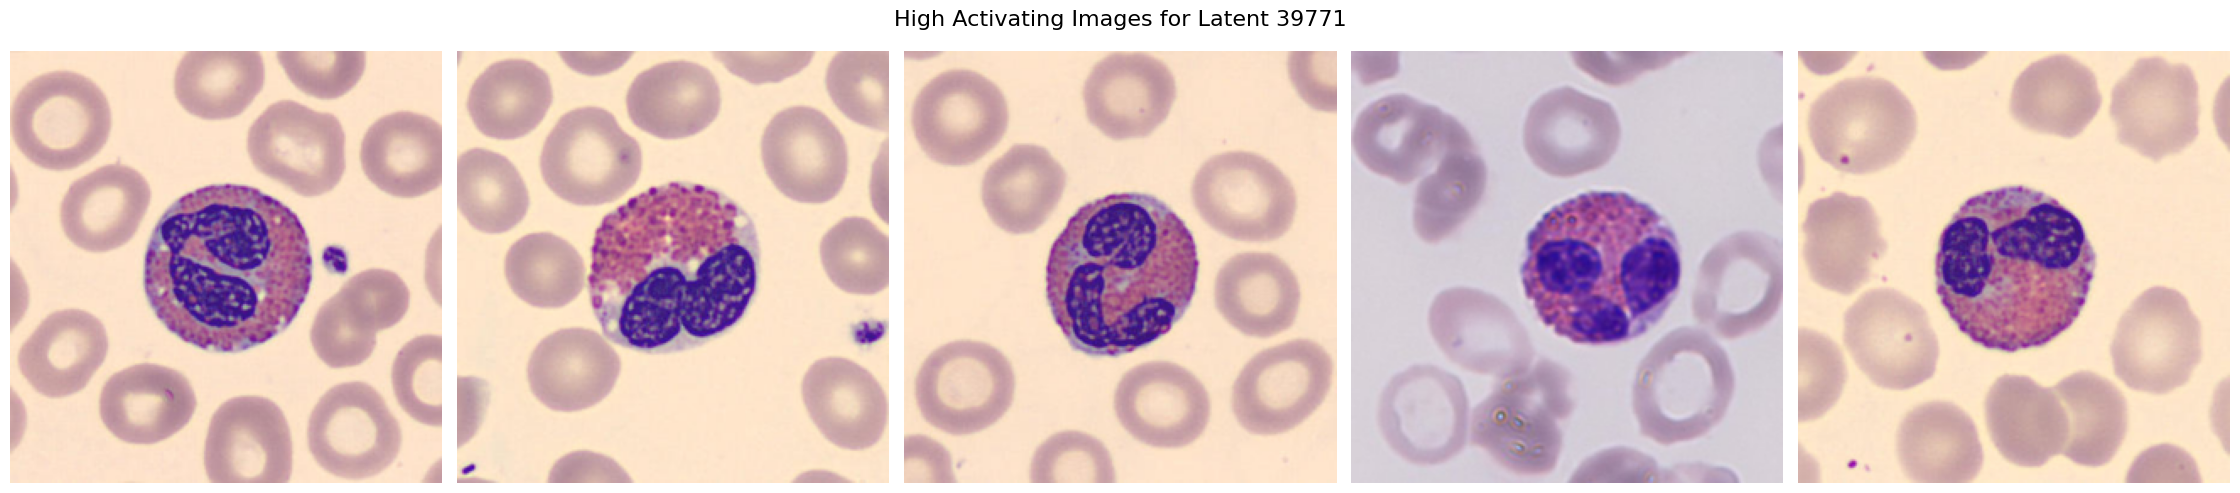

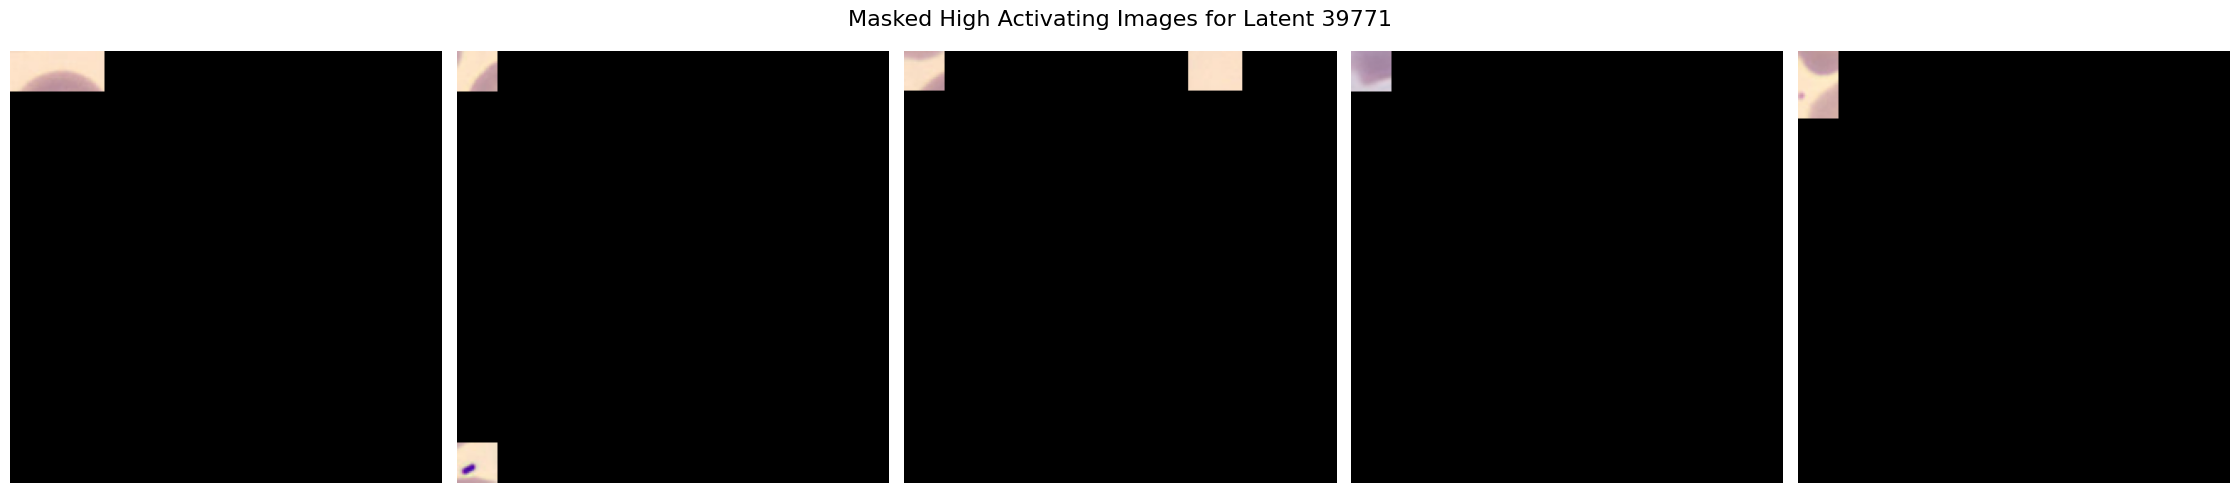

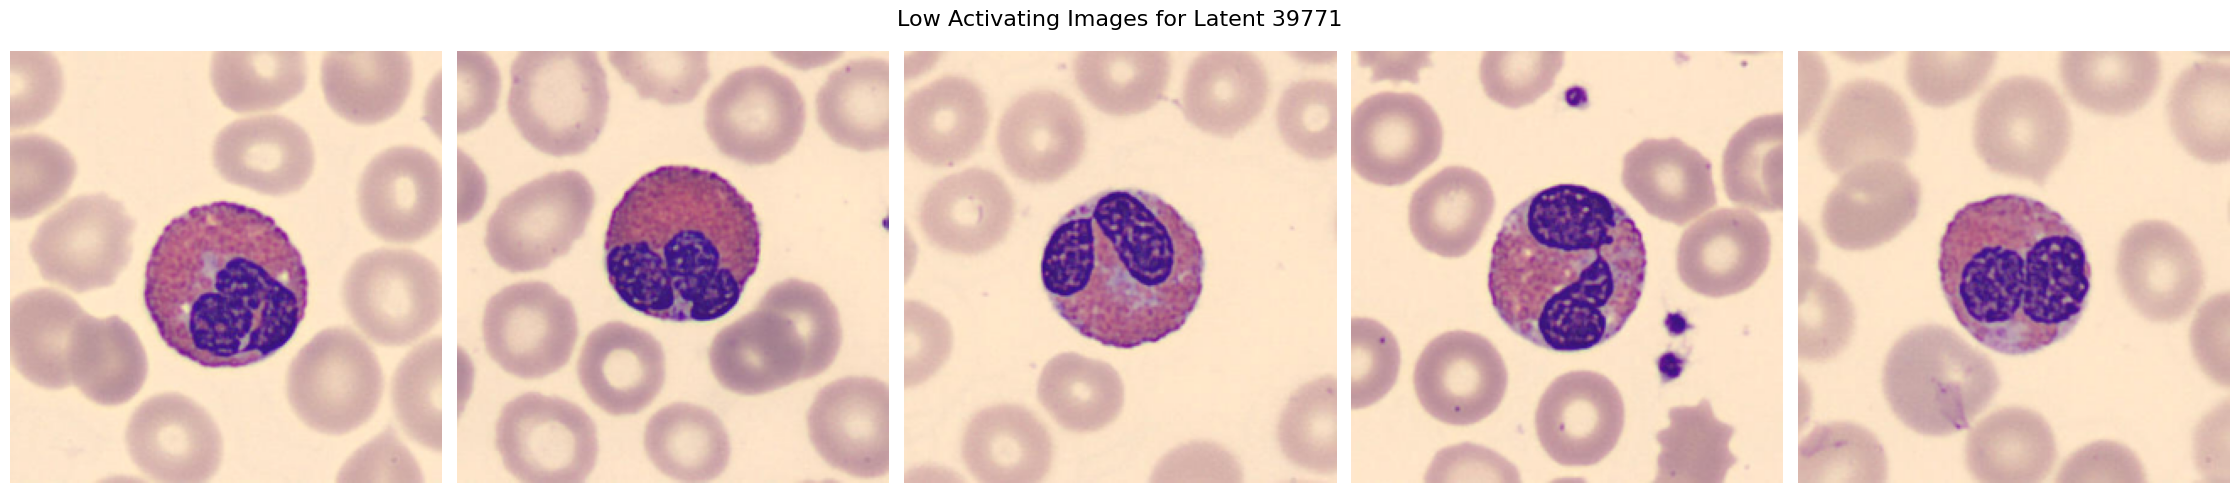

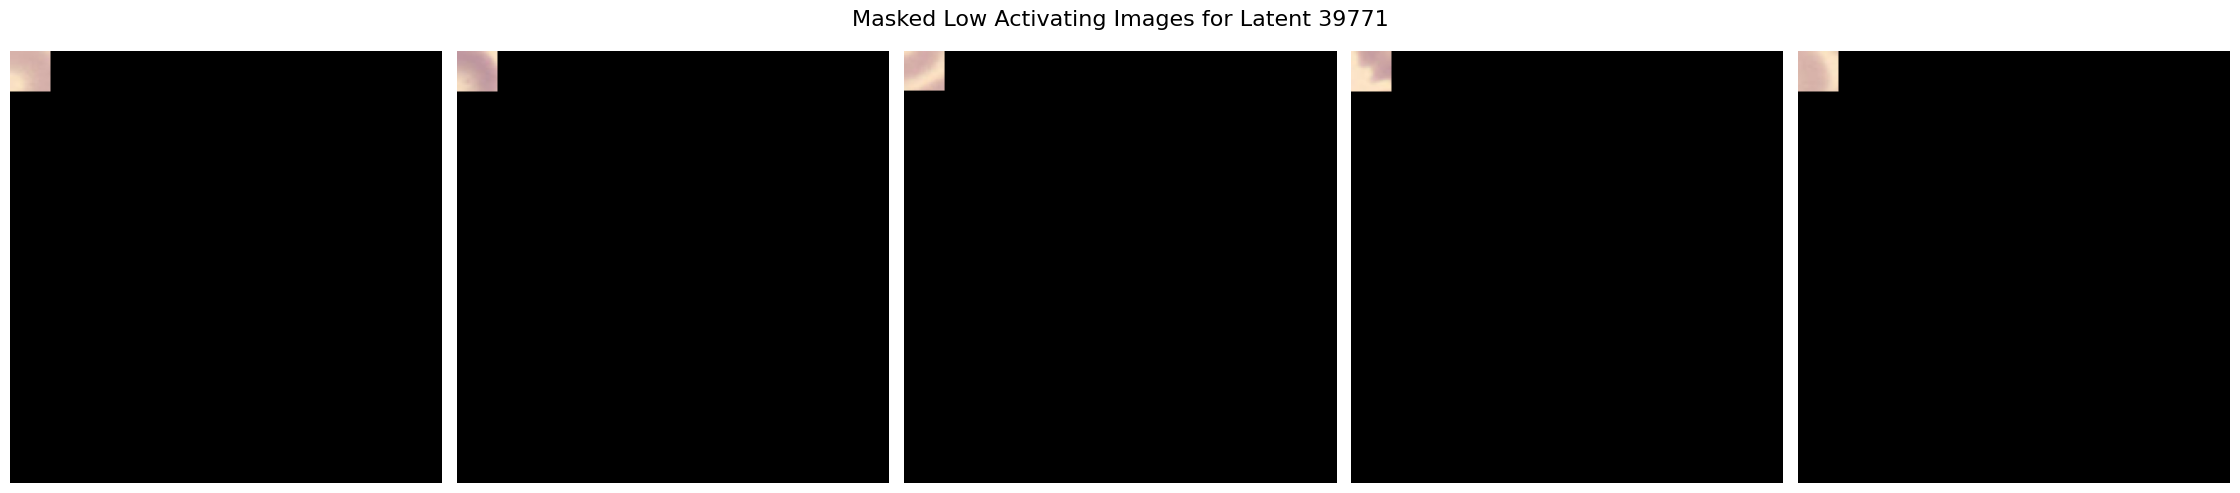

In [138]:
selected_latent = 39771

#concept_name = conceptscope.concept_dict[str(selected_latent)]
#plot_ref_images(checkpoint_name, selected_latent, concept_name=concept_name, save_root=save_root, show_title=True)

print('train')
plot_high_low_images(
    selected_latent,
    train_class_indices,
    train_class_activation,
    train_dataset,
    conceptscope.sae,
    conceptscope.vit,
    conceptscope.cfg,
    top_k=5,
    blend_rate_high=0.0,
    blend_rate_low=0.0,
    gamma=0.001,
    resize_size=256,
    percentile=0,
    device=device,
)

# print('test')
# plot_high_low_images(
#     selected_latent,
#     test_class_indices,
#     test_class_activation,
#     test_dataset,
#     conceptscope.sae,
#     conceptscope.vit,
#     conceptscope.cfg,
#     top_k=5,
#     blend_rate_high=0.0,
#     blend_rate_low=0.0,
#     gamma=0.001,
#     resize_size=256,
#     percentile=0,
#     device=device,
# )



